In [21]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sb
###

# Plot settings
%config InlineBackend.figure_format = 'svg'
sb.set()
from tqdm import tqdm
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
standard_scaler = StandardScaler()
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')
sys.path.append('/home/ak/Documents/PaperCode/stylised_facts')
import stylised_facts_data_utilities as sfd_utils
import lob_for_futures as lobfut
%matplotlib inline
import os

from scipy.stats import norm, ttest_ind

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
import logging


def logger(name, level=logging.INFO):
    tmp_logger = logging.getLogger(name)
    if not tmp_logger.handlers:
        formatter = logging.Formatter('%(asctime)s %(name)s  %(levelname)s %(message)s')
        handler = logging.StreamHandler()
        handler.setFormatter(formatter)

        tmp_logger.setLevel(level)
        tmp_logger.addHandler(handler)
    return tmp_logger

In [3]:
laptop_OS_folder = '/media/ak/OS/Data/FuturesDataSemiProcessed'
# LaCie_ProcessedData = '/media/ak/LaCie/ProcessedSampledData/'
# #returns_data = '/media/ak/T7/August11th2022Experiments/Returns/'
# t7 = '/media/ak/T7/'
# june_ext = os.path.join(t7, 'June4th2022Experiments')
# returns_data = [f for f in os.listdir(june_ext) if '_returns' in f]

In [4]:
symbols  = os.listdir(laptop_OS_folder)
symbol_test_folder  = os.path.join(laptop_OS_folder, symbols[0])
rx_folder = os.path.join(laptop_OS_folder, 'RX1')
files = os.listdir(rx_folder)


In [5]:
bar_keys = ['tick', 'volume', 'calendar', 'dollar']
files_idx = 5
date_idx = files[files_idx].split(".")[0]
idx_file = os.path.join(rx_folder, files[files_idx])
tick_df = pd.read_pickle(idx_file)[date_idx]['tick']
volume_df = pd.read_pickle(idx_file)[date_idx]['volume']
calendar_df = pd.read_pickle(idx_file)[date_idx]['calendar']
dollar_df = pd.read_pickle(idx_file)[date_idx]['dollar']




In [6]:
tick_df_micro = lobfut.apply_micro_structure_features(tick_df)
vol_class = lobfut.volatilityEstimation(tick_df)

Applying micro-structure features


In [7]:
GK_vol = list(vol_class.garmanKlass(5))

In [8]:
tick_experiment_df = pd.DataFrame()

In [22]:
def produce_experiment_data(chosen_df):
    # this is somewhat unit-tested
    # function to produce dataframes for experiments
    # written in August 202
    # re-write it as part of the _init_ file
    chosen_df_micro = lobfut.apply_micro_structure_features(chosen_df)  # get micro structure df
    vol_class = lobfut.volatilityEstimation(chosen_df)  # get the vol class

    # features I need: micro_price changes / vols /skews /etc:
    experiment_df = chosen_df_micro.loc[:, ['micro_price', 'price_imbalance',
                                            'pct_change_micro_price', 'weighted_activity_spread', ]]
    experiment_df['GK_vol'] = pd.Series(
        list(vol_class.garmanKlass(5)))  # get a sample of Garman - Klass resampled for 5 clicks
    experiment_df['arrival_rates'] = pd.Series(
        vol_class.arrival_rates().reshape(vol_class.arrival_rates().shape[0], )).replace([np.inf, -np.inf],
                                                                                         0).fillna(0)
    X = experiment_df.pct_change_micro_price.replace([np.inf, -np.inf], 0).values.reshape(-1, 1)
    norm_scaler = StandardScaler().fit(X)  # normalised scaling by mean and std
    min_max_scaler = MinMaxScaler().fit(X)  # min max scaling
    try:
        experiment_df['returns_normalised'] = norm_scaler.transform(
            X)  # use this format to get rid of the prior issues
        experiment_df['returns_mix_max'] = min_max_scaler.transform(X)  # get both issues of
        rs, rk = vol_class.realised_skewness_kurtosis()  # get skew/kurt

        experiment_df['skew'] = pd.Series(list(rs))
        experiment_df['kurt'] = pd.Series(list(rk))

        experiment_df['median_traded_volume'] = chosen_df_micro[['total_traded_volume_open',
                                                                 'total_traded_volume_high',
                                                                 'total_traded_volume_low',
                                                                 'total_traded_volume_close']].quantile(0.5, axis=1)
        experiment_df['jumps_test'] = pd.Series(vol_class.jumps_test(rollingWindow=5, sampling_param=0))
        experiment_df['relz_var'] = pd.Series(vol_class.realised_variance(rollingWindow=5))
        experiment_df['trip_quart'] = pd.Series(vol_class.tripower_quarticity(rollingWindow=5, sampling_param=0))

        experiment_df = experiment_df.replace([np.inf, -np.inf], 0).fillna(0)  # final clean up
    except ValueError:
        print("error")
        pass
    experiment_df = experiment_df.replace([np.inf, -np.inf], 0).fillna(0)  # final clean up

    return experiment_df


In [24]:
tick_experiment_df.head(5)

,bipower_variation,arrival_rates
tick_bucket,,
5.0,1.483507e-07,10.0
6.0,1.814466e-07,22.0
7.0,1.656795e-07,52.0
8.0,1.540913e-07,5.0
9.0,1.587338e-07,25.0


In [25]:
tick_experiment_df['bipower_variation'] = vol_class.bipower_variation()

In [26]:
tick_experiment_df['arrival_rates'] = pd.Series(vol_class.arrival_rates().reshape(vol_class.arrival_rates().shape[0],)).replace([np.inf, -np.inf], 0).fillna(0)

In [27]:
tick_experiment_df.arrival_rates.fillna(0)

x, y =vol_class.realised_skewness_kurtosis()

In [30]:
bar_keys = ['tick', 'volume', 'calendar', 'dollar']
files_idx = 5
date_idx = files[files_idx].split(".")[0]
idx_file = os.path.join(rx_folder, files[files_idx])
tick_df = pd.read_pickle(idx_file)[date_idx]['tick']
volume_df = pd.read_pickle(idx_file)[date_idx]['volume']
calendar_df = pd.read_pickle(idx_file)[date_idx]['calendar']
dollar_df = pd.read_pickle(idx_file)[date_idx]['dollar']

#  convert all the below into one function that reads a dataframe and spits out all the data we need
# make sure it is unit tested
def produce_experiment_data(chosen_df):
    # function to produce dataframes for experiments
    # written in August 202
    # re-write it as part of the _init_ file
    chosen_df_micro = lobfut.apply_micro_structure_features(chosen_df)  # get micro structure df
    vol_class = lobfut.volatilityEstimation(chosen_df)  # get the vol class

    # features I need: micro_price changes / vols /skews /etc:
    experiment_df = chosen_df_micro.loc[:, ['micro_price', 'price_imbalance',
                                               'pct_change_micro_price', 'weighted_activity_spread',]]
    experiment_df['GK_vol'] = pd.Series(list(vol_class.garmanKlass(5))) # get a sample of Garman - Klass resampled for 5 clicks
    experiment_df['arrival_rates'] = pd.Series(
        vol_class.arrival_rates().reshape(vol_class.arrival_rates().shape[0], )).replace([np.inf, -np.inf], 0).fillna(0)
    X = experiment_df.pct_change_micro_price.replace([np.inf, -np.inf], 0).values.reshape(-1, 1)
    scaler = StandardScaler().fit(X)
    min_max_scaler = MinMaxScaler().fit(X)
    try:
        experiment_df['returns_normalised'] = scaler.transform(X) # use this format to get rid of the prior issues
        experiment_df['returns_mix_max'] = min_max_scaler.transform(X) # get both issues of 
        rs, rk = vol_class.realised_skewness_kurtosis()  # get skew/kurt

        experiment_df['skew'] = pd.Series(list(rs))
        experiment_df['kurt'] = pd.Series(list(rk))

        experiment_df['median_traded_volume'] = chosen_df_micro[['total_traded_volume_open',
                                                                    'total_traded_volume_high', 'total_traded_volume_low',
                                                                    'total_traded_volume_close']].quantile(0.5, axis=1)
        experiment_df['jumps_test'] = pd.Series(vol_class.jumps_test(rollingWindow=5, sampling_param=0))
        experiment_df['relz_var'] = pd.Series(vol_class.realised_variance( rollingWindow=5))
        experiment_df['trip_quart'] = pd.Series(vol_class.tripower_quarticity(rollingWindow=5, sampling_param=0))

        experiment_df = experiment_df.replace([np.inf, -np.inf], 0).fillna(0) # final clean up
    except ValueError:
        print("error")
        pass
    experiment_df = experiment_df.replace([np.inf, -np.inf], 0).fillna(0) # final clean up
    
    return experiment_df

In [31]:
chosen_df = volume_df
output_df = produce_experiment_data(chosen_df)
# there is a bug on dollar df to work out

Applying micro-structure features


/home/ak/anaconda3/envs/newTimeSeries/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ak/anaconda3/envs/newTimeSeries/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
output_df.columns.values

array(['micro_price', 'price_imbalance', 'pct_change_micro_price',
       'weighted_activity_spread', 'GK_vol', 'arrival_rates',
       'returns_normalised', 'returns_mix_max', 'skew', 'kurt',
       'median_traded_volume', 'jumps_test', 'relz_var', 'trip_quart'],
      dtype=object)

In [33]:
output_df.head(5).T

,0,1,2,3,4
micro_price,158.370418,1.583704e+02,1.583704e+02,158.376171,158.385854
price_imbalance,-145.137624,-1.450332e+02,-1.449270e+02,-124.709698,27.046341
pct_change_micro_price,0.000000,2.082499e-08,2.115642e-08,0.000101,-0.000007
weighted_activity_spread,0.010000,1.000000e-02,1.000000e-02,0.010387,0.010000
GK_vol,0.000090,8.955168e-05,9.389273e-05,0.000100,0.000097
arrival_rates,1.000000,1.000000e+00,1.000000e+00,1.000000,2.000000
returns_normalised,0.000000,1.382652e-04,1.521740e-04,4.255489,-0.274158
returns_mix_max,0.000000,5.415881e-01,5.415887e-01,0.719457,0.530123
skew,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
kurt,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000


In [35]:
unit_test = output_df.pct_change_micro_price.values
unit_test

array([ 0.00000000e+00,  2.08249902e-08,  2.11564219e-08, ...,
       -2.38086306e-05,  1.02787550e-05,  7.60219587e-06])

In [36]:
import sklearn.preprocessing as preprocessing
X = output_df.pct_change_micro_price.values.reshape(-1, 1)

# normal 
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
print( X_scaled.mean(), X_scaled.std())

7.811274744695883e-18 1.0


In [37]:
min_max_scaler = preprocessing.MinMaxScaler().fit(X)
X_min_max_scaled = min_max_scaler.transform(X)
print( X_min_max_scaled.mean(), X_min_max_scaled.std())

0.541582348260156 0.0417985670666089


In [39]:
# ## fucked up unit test
# files_idx = 5
# for files_idx in range(0, 5):
#     date_idx = files[files_idx].split(".")[0]
#     idx_file = os.path.join(rx_folder, files[files_idx])
# #     tick_df = pd.read_pickle(idx_file)[date_idx]['tick']
# #     volume_df = pd.read_pickle(idx_file)[date_idx]['volume']
# #     calendar_df = pd.read_pickle(idx_file)[date_idx]['calendar']
#     dollar_df = pd.read_pickle(idx_file)[date_idx]['dollar']
#     chosen_df = dollar_df
#     output_df = produce_experiment_data(chosen_df)
#     print(output_df.head(5).T)


In [41]:
output_df.columns.values

array(['micro_price', 'price_imbalance', 'pct_change_micro_price',
       'weighted_activity_spread', 'GK_vol', 'arrival_rates',
       'returns_normalised', 'returns_mix_max', 'skew', 'kurt',
       'median_traded_volume'], dtype=object)

In [42]:
import fathon
from fathon import fathonUtils as fu


In [ ]:
winSizes = fu.linRangeByStep(5, 20)
qs = np.arange(-3, 4, 0.1)
revSeg = True
polOrd = 1
n, F = pymfdfa.computeFlucVec(winSizes, qs, revSeg=revSeg, polOrd=polOrd)

In [ ]:
list_H, list_H_intercept = pymfdfa.fitFlucVec()

In [ ]:
plt.plot(np.log(n), np.log(F[0, :]), 'ro')
plt.plot(np.log(n), list_H_intercept[0]+list_H[0]*np.log(n), '--', label='h_{:.1f} = {:.2f}'.format(qs[0], list_H[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(n), np.log(F[half_idx, :]), 'co')
# plt.plot(np.log(n), list_H_intercept[half_idx]+list_H[half_idx]*np.log(n),
#          '--', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], list_H[half_idx]))
plt.plot(np.log(n), np.log(F[-1, :]), 'yo')
plt.plot(np.log(n), list_H_intercept[-1]+list_H[-1]*np.log(n), '--',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], list_H[-1]))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('MFDFA', fontsize=14)
plt.legend(loc=0, fontsize=14)

In [ ]:
list_H, list_H_intercept = pymfdfa.fitFlucVec()

In [ ]:
## replicating old malarkey below

In [ ]:
tick_standard = (tr - tr.mean()) / tr.std()
volume_standard = (vr - vr.mean()) / vr.std()
dollar_standard = (dr - dr.mean()) / dr.std()
calendar_standard = (cr - cr.mean()) / cr.std()

In [ ]:
fig, ax = plt.subplots()
#sns.kdeplot(time_standard, label="Time", bw=0.30, color='darkred')
# sns.kdeplot(tick_standard, 
#             ax=ax,
#             label="Tick", 
#             bw=0.25,
#             color='darkblue')
sns.kdeplot(volume_standard,
            ax=ax,
            label="Volume",
            bw=0.25,
            color='lightgreen')
sns.kdeplot(dollar_standard,
            ax=ax,
            label="Dollar",
            bw=0.25,
            linewidth=2,
            color='darkcyan')
sns.kdeplot(np.random.normal(size=len(tick_standard)),
            ax=ax,
            label="Normal",
            color='black',
            linewidth=2,
            linestyle="--")
plt.legend()

In [ ]:
experimentsLocation = '/media/ak/T7/August11th2022Experiments/'
os.listdir(experimentsLocation)

In [ ]:
file_test = os.path.join(experimentsLocation, 'RX1_20180417_experiments_dict.pkl')

In [ ]:
test_df = pd.read_pickle(file_test)

In [ ]:
test_df['tick']

In [16]:
test_df['volume']

NameError: name 'test_df' is not defined

In [17]:
test_df['calendar']

NameError: name 'test_df' is not defined

In [18]:
test_df['tick'].columns.values

NameError: name 'test_df' is not defined

In [19]:
returns_normalised_ticks = test_df['tick'].returns_normalised.values

NameError: name 'test_df' is not defined

In [183]:
x = returns_normalised_ticks

In [34]:
import fathon
from fathon import fathonUtils as fu


This is fathon v1.2


In [84]:
print(tick_experiment_df.columns.values)

['micro_price' 'price_imbalance' 'pct_change_micro_price'
 'weighted_activity_spread' 'GK_vol' 'arrival_rates' 'returns_normalised'
 'returns_mix_max' 'skew' 'kurt' 'median_traded_volume' 'jumps_test'
 'relz_var' 'trip_quart' 'bipower_variation']


In [36]:
# refactoring MFDFA functions

In [82]:
# import fathon
# import pandas as pd
# from fathon import fathonUtils as fu
# import numpy as np




In [87]:

activity_spread = tick_experiment_df.weighted_activity_spread.fillna(0).values
returns_normalised = tick_experiment_df.returns_normalised.fillna(0).values
relz_var = tick_experiment_df.relz_var
returns_min_max = tick_experiment_df.returns_mix_max

In [60]:

a = fu.toAggregated(returns_normalised)
b = fu.toAggregated(activity_spread)


In [88]:

winSizes = fu.linRangeByStep(10, 1000)
qs = np.arange(-3, 4, 0.1)
revSeg = True
polOrd = 1


In [89]:
c = to_agg(relz_var)
d = to_agg(returns_min_max)

In [91]:
mfdfa_c = fathon.MFDFA(c)
mfdfa_d = fathon.MFDFA(d)


In [93]:
n_c, F_c = n_F_output(mfdfa_c, winSizes,qs, revSeg, polOrd)

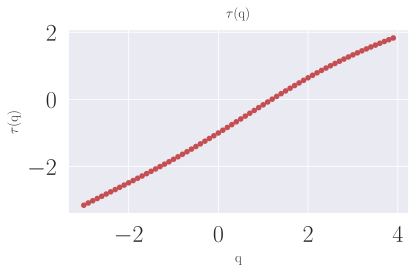

In [99]:
tau_c = mfdfa_c.computeMassExponents()
plt.plot(qs, tau_c, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
plt.title('$\\tau$(q)', fontsize=14)
plt.show()


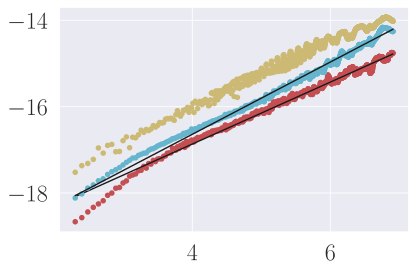

In [96]:
list_H, list_H_intercept = mfdfa_c.fitFlucVec()

plt.plot(np.log(n_c), np.log(F_c[0, :]), 'ro')
plt.plot(np.log(n_c), list_H_intercept[0]+list_H[0]*np.log(n_c), 'k-', label='h_{:.1f} = {:.2f}'.format(qs[0], list_H[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(n_c), np.log(F_c[half_idx, :]), 'co')
plt.plot(np.log(n_c), list_H_intercept[half_idx]+list_H[half_idx]*np.log(n_c),
         'k-', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], list_H[half_idx]))
plt.plot(np.log(n_c), np.log(F_c[-1, :]), 'yo')


In [102]:
mfdfa_output_dict= dict()
mfdfa_output_dict ={'n':n_c,
             'F':F_c,
             'list_H':list_H,
             'list_H_intercept': list_H_intercept,
             'tau': tau_c,
             'alpha': alpha,
             'mfSpect': mfSpect_c}
# structure of the output dictionary

In [101]:
alpha_c, mfSpect_c = compute_multi_fractal_spectrum(mfdfa_c)

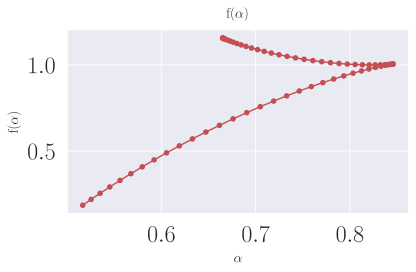

In [103]:
plt.plot(alpha_c, mfSpect_c, 'ro-')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
plt.title('f($\\alpha$)', fontsize=14)
plt.show()


In [115]:
def mfdfa_experiment_output_storage(data_input, winSizes,qs, revSeg, polOrd):
    """
    data_input: takes data input from the experiment df
    """
    agg_data = to_agg(data_input) 
    # does the first bit - Subtracts mean of a vector and computes the cumulative sum."""
    mfdfa_ = fathon.MFDFA(agg_data)
    alpha, mfSpect = compute_multi_fractal_spectrum(mfdfa_) # figure out why this does not cmpute
    n, F = n_F_output(mfdfa_, winSizes,qs, revSeg, polOrd)
    list_H, list_H_intercept = mfdfa_.fitFlucVec()
    mfdfa_output_dict ={'n':n,
             'F':F,
             'list_H':list_H,
             'list_H_intercept': list_H_intercept,
             'tau': tau}
    return mfdfa_output_dict
    

In [117]:
test = mfdfa_experiment_output_storage(c, winSizes,qs, revSeg, polOrd)

Nothing to fit, fluctuations vector has not been computed yet.


TypeError: 'NoneType' object is not iterable

In [ ]:
mfdfa_c.computeMassExponents()

In [114]:
compute_multi_fractal_spectrum(mfdfa_c)

(array([0.66667617, 0.66579421, 0.66522537, 0.66500481, 0.66516909,
        0.66575569, 0.66680248, 0.66834694, 0.67042522, 0.67307099,
        0.67631414, 0.68017924, 0.68468392, 0.68983714, 0.69563748,
        0.70207152, 0.70911249, 0.71671929, 0.72483604, 0.73339213,
        0.74230313, 0.75147225, 0.76079245, 0.77014915, 0.7794232 ,
        0.78849398, 0.79724247, 0.80555402, 0.81332061, 0.82044271,
        0.82683046, 0.83240436, 0.83709549, 0.84084534, 0.8436054 ,
        0.84533661, 0.8460088 , 0.84560011, 0.84409662, 0.84149207,
        0.83778774, 0.83299252, 0.82712313, 0.82020435, 0.81226942,
        0.80336038, 0.79352826, 0.78283326, 0.77134466, 0.75914045,
        0.74630678, 0.73293697, 0.71913035, 0.70499074, 0.69062473,
        0.67613983, 0.66164243, 0.64723588, 0.63301853, 0.619082  ,
        0.60550958, 0.59237503, 0.57974163, 0.56766161, 0.55617593,
        0.54531447, 0.53509643, 0.52553109, 0.51661874]),
 array([1.15139631, 1.15395401, 1.15554676, 1.15614226, 1.